In [1]:
from scipy.ndimage.morphology import binary_hit_or_miss
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect
import scipy.stats

from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin,
                               opening
                              )
from skimage.measure import find_contours
from skimage.filters import rank
from skimage.draw import rectangle
from skimage.filters import threshold_otsu, gaussian
from skimage import feature


In [2]:
import cv2
if ' ':
    print('hi')
    
def cv_show(image):
    image=np.uint8(image)
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

hi


In [3]:
# omar do those
def which_number(num_image):
    """
    returns: zero is image wasn't a number
    or returns the number that it represents either
    1, 2, 3, 4, ...., 9
    
    arguments:
    num_image: this is an image of small size
    """
    pass

def which_symbol_division(sym_image):
    """
    returns which duration eg, if a/4 return 4, if a/8 return 8, if a/16, a/32 
    if not any one return 0
    
    arguments:
    sym_image: this is an image of small size
    """
    pass



In [4]:
# atia do this


def number_of_beams(sym_image):
    """
    returns the number of beams that are found in beaming symbols    
    arguments:
    sym_image: this is an image of small size
    """
    pass

def filled_holes_centers(sym_image):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size
    """
    pass

def which_accidentals(sym_image):
    """
    returns: accidental is found in that image
    returns '#' if # or '&' if b or ' '(space) if neutral '##' if X '&&' if bb
    or return ''(empty) or None if not any of these
    arguments:
    sym_image: this is an image of small size
    """
    pass

In [5]:
def remove_horizontal_lines(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max = h
    for c in cnts:   
#         print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
#         cv2.imshow('result', gray)
#         cv2.waitKey()
#     cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
#     print("repair", repair_kernel)
    result = 255-cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
#     cv2.imshow('result', gray)
#     cv2.waitKey()
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return h_max,result

In [14]:
# common functions
def read_Image(imgLocation):
    original_image = io.imread(imgLocation)
    if len(original_image.shape) != 2:
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = original_image
    binary_image = binarize(gray_image)
    return binary_image
def binary_opening(img, selem):
    return binary_dilation(binary_erosion(img, selem=selem), selem=selem)
def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns the bounding boxes sorted according to x-min
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8)
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        if(Ymax-Ymin != 0):
            aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        else:
            aspect_ratio = 3000
            
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
    
    
    def x_min(shape):
        return shape[0]             

    bounding_boxes = sorted(bounding_boxes, key=x_min)
    
    no_duplicated_boxes=[bounding_boxes[0]]
    for i in range(1, len(bounding_boxes)):
        pre_box=bounding_boxes[i-1]
        curr_box = bounding_boxes[i]
        if curr_box[0] >= pre_box[0] and curr_box[1] <= pre_box[1] and curr_box[2] >= pre_box[2] and curr_box[3]<= pre_box[3]:
            continue
        else:
            no_duplicated_boxes.append(curr_box)
        print(pre_box," --- " ,curr_box)
    return no_duplicated_boxes


def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


In [15]:
# Features DataBase

In [16]:
Symbol_Locations = ['images/Notes/Quarter-Note.png','images/Notes/Half-Note.png','images/Notes/Whole-Note.png','images/Notes/Flat-Note.jpg','images/Notes/Double-Flat-Note.png','images/Notes/Sharp-Note.png','images/Notes/Double-Sharp-Note.png','images/Notes/Natural-Note.png']

sift = cv2.SIFT_create()
DataBase = []

for Location in Symbol_Locations:
    binary_image = read_Image(Location)
    [ keypoints , descriptors ] = sift.detectAndCompute(binary_image,None)
    DataBase.append([ keypoints  , descriptors ])
    print(Location)
    print(len(keypoints),len(descriptors))
    print()
    

images/Notes/Quarter-Note.png
28 28

images/Notes/Half-Note.png
11 11

images/Notes/Whole-Note.png
15 15

images/Notes/Flat-Note.jpg
33 33

images/Notes/Double-Flat-Note.png
24 24

images/Notes/Sharp-Note.png
57 57

images/Notes/Double-Sharp-Note.png
66 66

images/Notes/Natural-Note.png
19 19



[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


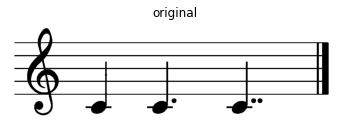

In [8]:
# images_paths = ['images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
images_paths = [ f"test-cases/0{i+1}.PNG" for i in range(9)]

original_image = io.imread(images_paths[5])
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
print(binary_image)
inverted_image = 255 - binary_image
show_images([binary_image],['original'])

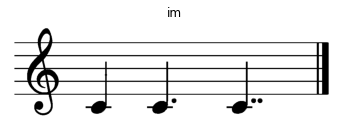

[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
(349, 1129)


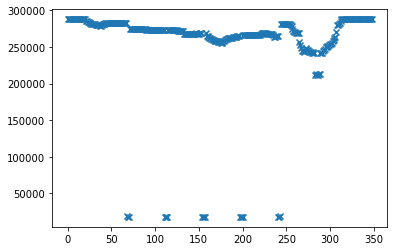

In [9]:
# binary_image = binary_image/255

image = binary_image

show_images([image], ['im'])
print(image)
row_sums=np.zeros(image.shape[0])
for row in range(image.shape[0]):
    row_sums[row] = np.sum(image[row,:])
#     print(row_sums[row])
# for s in row_sums:
#     print(row)
indices = [i for  i in range(image.shape[0])]
plt.scatter(indices, row_sums, marker='x')
print(image.shape)
# print("max: ",np.max(row_sums))
# for i, s in enumerate(row_sums):
#     print(s)

In [12]:
# images_paths = ['images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
# images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
images_paths = [ f"test-cases/0{i+1}.png" for i in range(9)]

original_image = io.imread(images_paths[5])
gray_image = rgb2gray(original_image)
show_images([gray_image], ['gray'])
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image

inverted_image[:, inverted_image.shape[1]-1]=0
rows=1
cols=image.shape[1] // 4
selem = rect(rows,cols)
erroded_img = binary_erosion(inverted_image,selem=selem)

rows=1
cols=image.shape[1] // 4
selem = rect(rows,cols)
erroded_img2 = binary_dilation(erroded_img, selem=selem)
# inverted_image2 = inverted_image - erroded_img2

show_images([erroded_img2], ['erroded2'])
print(erroded_img)
rows = image.shape[0] // 8
cols = 1
selem = rect(rows,cols)
closed_img  = binary_closing(erroded_img2, selem = selem)


# closed_img  = binary_closing(closed_img, selem = selem)
show_images([inverted_image,erroded_img2,closed_img],['original image','erroded-dilated','closed'])

staffs_area = np.sum(erroded_img2)
print(staffs_area)

FileNotFoundError: No such file: '/home/ahmed/Desktop/Work/GitRepos/music-notes-reader/test-cases/06.png'

In [10]:
#  calculate the trace bounding boxes
trace_bounding_boxes = get_bounding_boxes(closed_img,(5,4000))
# print(trace_bounding_boxes)
bigger_trace_bounding_boxes = []
trace_images_array = []
division_height=0
trace_height = 0
for box in trace_bounding_boxes:
    trace_height = box[3]-box[2]
    trace_width = box[1] - box[0]
    division_height = (trace_height)/4
    division_height = int(np.ceil(division_height)) 
#     division_height *=2
    [Xmin, Xmax, Ymin, Ymax] = [int(round(x)) for x in box]
    Ymin -= 2 * division_height
    Ymin = Ymin if Ymin >0 else 0
    Ymax += 2 * division_height
    bigger_trace_bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    
    trace_images_array.append(gray_image[Ymin:Ymax,Xmin:Xmax])
staff_length = bigger_trace_bounding_boxes

# print(staffs_area, trace_width)

# print(staffs_area // (len(bigger_trace_bounding_boxes) * 5 *trace_width ))

# print(bigger_trace_bounding_boxes)
# print(inverted_image.shape)

NameError: name 'closed_img' is not defined

In [70]:
print(inverted_image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


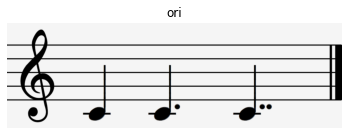

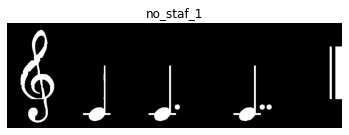

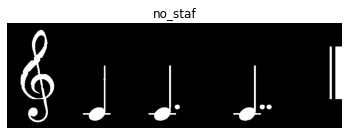

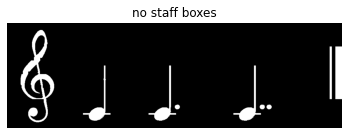

[55, 113, 130, 237]  ---  [88, 119, 38, 101]
[88, 119, 38, 101]  ---  [109, 137, 176, 233]
[109, 137, 176, 233]  ---  [240, 326, 134, 307]
[299, 299, 300, 300]  ---  [302, 302, 297, 297]
[302, 302, 297, 297]  ---  [303, 303, 296, 296]
[303, 303, 296, 296]  ---  [447, 533, 134, 307]
[447, 533, 134, 307]  ---  [530, 545, 257, 271]
[530, 545, 257, 271]  ---  [715, 801, 134, 307]
[777, 777, 297, 297]  ---  [778, 778, 296, 296]
[778, 778, 296, 296]  ---  [798, 813, 257, 271]
[798, 813, 257, 271]  ---  [819, 835, 257, 271]
[819, 835, 257, 271]  ---  [1019, 1025, 74, 239]
[1019, 1025, 74, 239]  ---  [1037, 1057, 74, 239]
[43, 148, 22, 312]


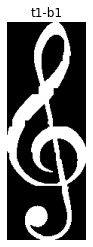

[88, 119, 38, 101]


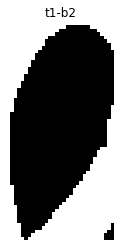

[109, 137, 176, 233]


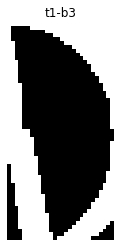

[240, 326, 134, 307]


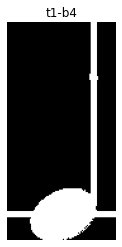

[302, 302, 297, 297]


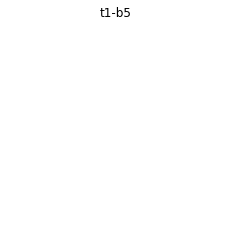

[303, 303, 296, 296]


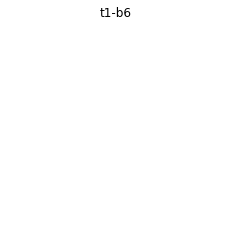

[447, 533, 134, 307]


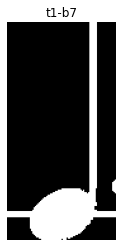

[530, 545, 257, 271]


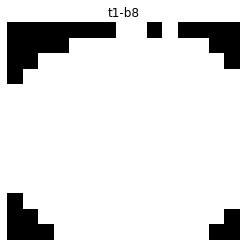

[715, 801, 134, 307]


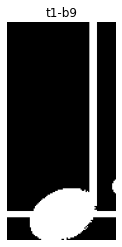

[778, 778, 296, 296]


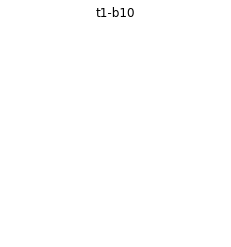

[798, 813, 257, 271]


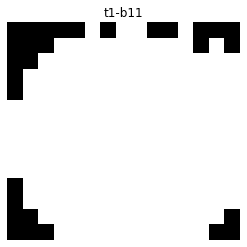

[819, 835, 257, 271]


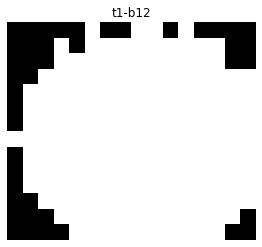

[1019, 1025, 74, 239]


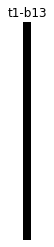

[1037, 1057, 74, 239]


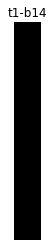

In [71]:
# for each trace segment the individual characters
staff_images = []
gray_staff_images=[]
sh = lambda x: print ("shape is ",x.shape)
line_height = 3
for i, trace in enumerate(bigger_trace_bounding_boxes):
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    show_images([original_image[Ymin:Ymax,Xmin:Xmax]], ['ori'])
#     line_width, no_staf_1 = remove_horizontal_lines_old(original_image[Ymin:Ymax,Xmin:Xmax])
    line_width, no_staf_1 = remove_horizontal_lines(original_image[Ymin:Ymax,Xmin:Xmax])
    # close the no_staf_2
#     no_staf_2 = binary_opening(no_staf_2, rect(2,2))
    show_images([no_staf_1], ['no_staf_1'])

    no_staf_1[no_staf_1 == 255] = True
    no_staf_1[no_staf_1 == 0] = False
    
#     no_staf_2[no_staf_2 == 255] = True
#     no_staf_2[no_staf_2 == 0] = False
    org_inverted = inverted_image[Ymin:Ymax,Xmin:Xmax].astype(np.uint8)
    
    org_inverted[org_inverted==255] = True
    org_inverted[org_inverted==0] = False    
#     print(no_staf_1)
    
    #show_images([no_staf_1, no_staf_2], ['no_staf1','no_staf2'])
#     no_staf = np.bitwise_or(no_staf_1, no_staf_2)
    no_staf = no_staf_1
    no_staf = np.bitwise_and(no_staf, org_inverted)
#     open no_staff
#     no_staf = binary_opening(no_staf, rect(2,2))
#     no_staf = np.bitwise_and(no_staf, org_inverted)

    
    show_images([no_staf], ['no_staf'])    
#     vertical_lines = binary_erosion(inverted_image[Ymin:Ymax,Xmin:Xmax], selem=rect(division_height*2,1))
#     vertical_lines = binary_dilation(vertical_lines, selem=rect(division_height*2,1))
    
#     no_staf = np.bitwise_or(no_staf, vertical_lines)
    
#     show_images([no_staf], ['no_staf with vertical'])    
    
#     show_images([inverted_image[Ymin:Ymax,Xmin:Xmax]], ['img'])
    no_staf_boxes = no_staf
#     no_staf_boxes = binary_dilation(no_staf, selem=rect(4,4))
    
#     no_staf_boxes = binary_dilation(no_staf_boxes, selem=rect(20,1))
#     no_staf_boxes = binary_dilation(no_staf_boxes, selem=rect(5,5))
    
    
    show_images([no_staf_boxes], ['no staff boxes'])
    char_boxes = get_bounding_boxes(no_staf_boxes, (0,200))
    
    j=0
    chars = []
    for box in char_boxes:
        print(box)
        [Xmin, Xmax, Ymin, Ymax] = [x for x in box]
        # remove blank or noisy area that is less than a line of pixels
        char = no_staf[Ymin:Ymax,Xmin:Xmax]
        show_images([char],[f't{i+1}-b{j+1}'])
#         if(np.sum(char)+5 > trace_height):
        
        chars.append(char)
#         char[char==True] = 255
#         char[char==False] = 0
#         io.imsave(f'no_line_test/t{i+1}-b{j+1}.bmp', char)

        j+=1
    staff_images.append(chars)



In [ ]:
for staff_chars in staff_images:
    j=0
    j+=1
    for char in staff_chars:
        i=0
        i+=1
        show_images([char],[f"char {j}-{i}"])
        
        
        
        

In [ ]:

from skimage import data
from skimage.viewer import ImageViewer

image = original_image
viewer = ImageViewer(image)
viewer.show()

In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))


image = cv2.imread('images/8th_Sheet1.jpeg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))

# thresh = cv2.Canny(thresh, 30, 200) 
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# print(cnts)
cont_areas = get_avg_contour_areas(cnts)
print("avg" , cont_areas)
for c in cnts:
    print(len(c))
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    print(cv2.boundingRect(c))
    cv2.imshow('result', image)
    cv2.waitKey()
cv2.destroyAllWindows()

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
print("repair", repair_kernel)
result = cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
kernel = np.ones((1,15),np.uint8)
# er = cv2.dilate(result,kernel,iterations = 1)


showHist(result)
cv2.imshow('thresh', thresh)
cv2.imshow('detected_lines', detected_lines)
cv2.imshow('image', image)
# cv2.imshow('er', er)
cv2.imshow('result', result)
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))
# images_paths = [ f"test-cases/0{i+1}.png" for i in range(9)]
images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
for image_path in images_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # print(cnts)
    cont_areas = get_avg_contour_areas(cnts)
#     print("avg" , cont_areas)
    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max = h
    for c in cnts:   
#         print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
        cv2.imshow('result', gray)
        cv2.waitKey()
    cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
#     print("repair", repair_kernel)
    result = cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    showHist(result)
    cv2.imshow('thresh', thresh)
    cv2.imshow('detected_lines', detected_lines)
    cv2.imshow('image', image)
    # cv2.imshow('er', er)
    cv2.imshow('result', result)
    cv2.waitKey()
    cv2.destroyAllWindows()


In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))


image = cv2.imread('images/8th_Sheet1.jpeg')  
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.destroyAllWindows()
showHist(thresh)



In [ ]:
m = [[0, 39, 10, 119], [18, 26, 17, 38], [814, 837, 20, 85], [409, 413, 32, 92], [721, 726, 32, 92], [1034, 1039, 32, 92], [59, 83, 33, 58], [118, 140, 36, 101], [188, 211, 36, 101], [258, 282, 36, 101], [431, 454, 36, 101], [501, 524, 36, 101], [571, 594, 36, 101], [744, 767, 36, 101], [66, 72, 42, 49], [954, 978, 48, 109], [877, 913, 53, 118], [5, 19, 54, 88], [59, 83, 65, 90], [17, 25, 70, 86], [28, 33, 71, 86], [66, 71, 75, 82], [1053, 1081, 85, 101], [577, 587, 87, 99], [1063, 1071, 87, 99], [265, 274, 88, 98]]
def x_min(shape):
    return shape[0]
m = sorted(m, key=x_min)
print(m)